In [20]:
import pandas as pd 
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
from urllib.parse import quote_plus

user = "SA"
password = quote_plus("Ali110110")
server = 'localhost:1433'
database = 'AdventureWorks2025'
driver = quote_plus("ODBC Driver 18 for SQL server")


connection_string = (
    f"mssql+pyodbc://{user}:{password}@{server}/{database}"
    f"?driver={driver}&Encrypt=yes&TrustServerCertificate=yes"
)

engine = create_engine(connection_string)


try:
    with engine.connect():
        print("Anslutning till SQL Server lyckades")
except Exception as e:
    print("Kunde inte ansluta", e)

Anslutning till SQL Server lyckades


C:\Users\benji\AppData\Local\Temp\ipykernel_31100\212979802.py:22: SAWarning: Unrecognized server version info '17.0.1000.7'.  Some SQL Server features may not function properly.
  with engine.connect():


# 1. Antal produkter per kategori

Affärsfråga: Hur många produkter finns i varje kategori?

Metod: Join mellan kategori, subkategori och produkt. Räkna unika produkter per kategori.

Insikt: Visualiseringen visar vilken kategori som har flest respektive minst produkter.

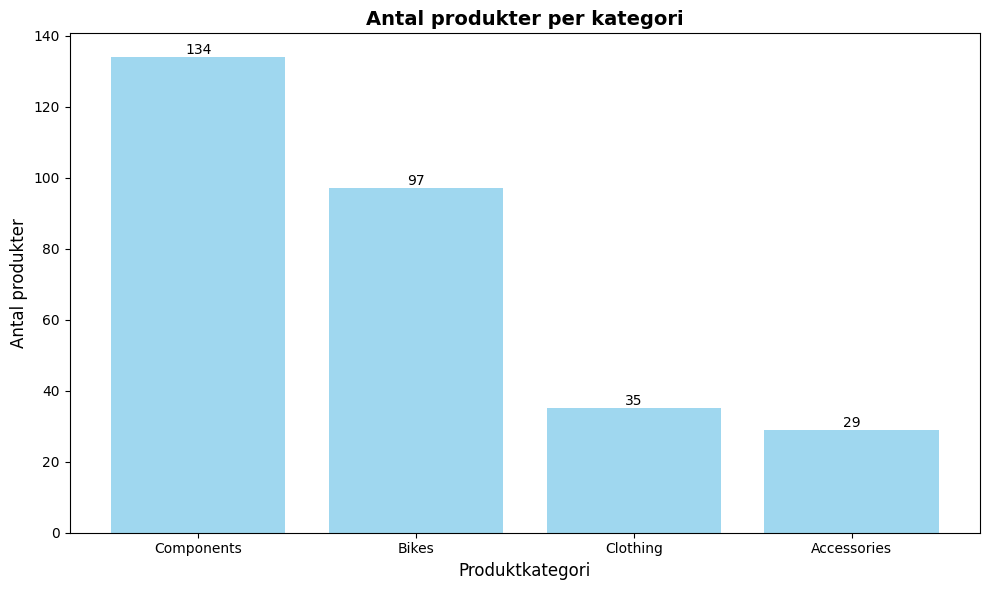

In [21]:
# Define the SQL query to get the number of products per category
query_vis1 = """
SELECT pc.Name AS Category, COUNT(DISTINCT p.ProductID) AS ProductCount
FROM Production.ProductCategory pc
JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
GROUP BY pc.Name 
ORDER BY ProductCount DESC
"""

# Execute the SQL query and load the result into a pandas DataFrame
df = pd.read_sql(query_vis1, engine)

# Create a matplotlib figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot a bar chart: x = Category, y = ProductCount
bars = ax.bar(df['Category'], df['ProductCount'], color='skyblue', alpha=0.8)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{int(height)}',
        ha='center',
        va='bottom'
    )
   
# Set the title and labels
ax.set_title('Antal produkter per kategori', fontsize=14, fontweight='bold')
ax.set_xlabel('Produktkategori', fontsize=12)
ax.set_ylabel('Antal produkter', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

# 2. Försäljning per produktkategori

Affärsfråga: Vilka produktkategorier genererar mest intäkter?

Metod: Summera LineTotal per kategori och sortera fallande.

Insikt: Kategorin högst upp har störst försäljning, längst ned minst (exakta siffror kan avläsas).

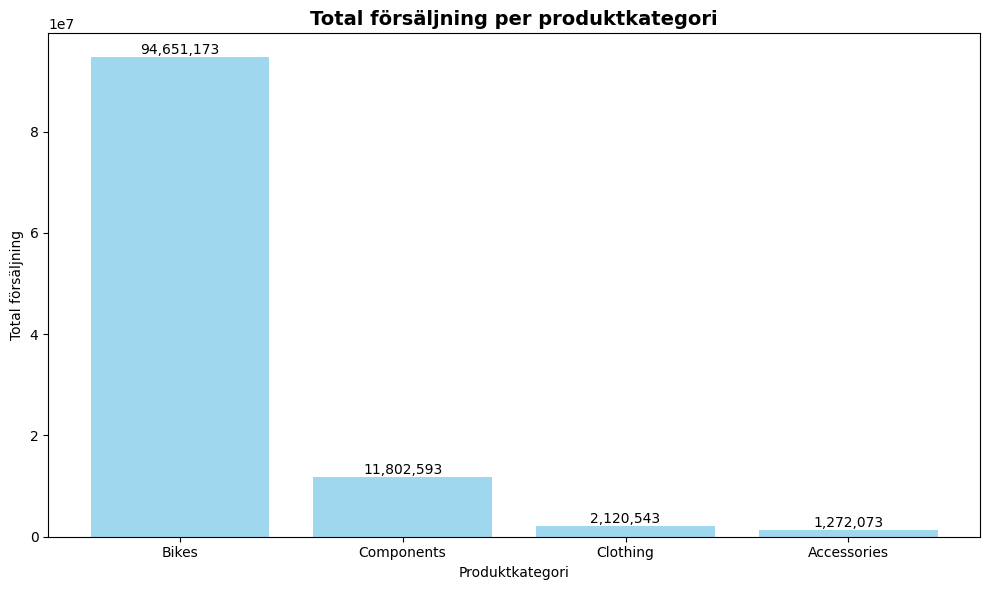

In [22]:
# Define SQL query to calculate total sales per product category
query_vis2 = """
SELECT pc.Name AS Category,
       SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
-- Join Product to link order details to products
JOIN Production.Product p 
    ON sod.ProductID = p.ProductID
-- Join ProductSubcategory to link products to subcategories
JOIN Production.ProductSubcategory psc 
    ON p.ProductSubcategoryID = psc.ProductSubcategoryID
-- Join ProductCategory to get the category for each product
JOIN Production.ProductCategory pc 
    ON psc.ProductCategoryID = pc.ProductCategoryID
-- Group by category to sum sales per category
GROUP BY pc.Name
-- Order by total sales descending to show top-selling categories first
ORDER BY TotalSales DESC
"""

# Execute SQL query and load results into a pandas DataFrame
df = pd.read_sql(query_vis2, engine)

# Create a matplotlib figure and axis object for vertical bar chart
fig, ax = plt.subplots(figsize=(10, 6))  # Set figure size (width x height)

# Plot vertical bar chart: x = Category, y = TotalSales
bars = ax.bar(df['Category'], df['TotalSales'], color='skyblue', alpha=0.8)
# color sets bar color, alpha sets transparency

# Add labels on top of each bar showing the exact total sales
for bar in bars:
    height = bar.get_height()  # Get the height of the bar (TotalSales)
    ax.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate: center of the bar
        height,                              # Y-coordinate: top of the bar
        f'{height:,.0f}',                    # Format the number with commas, no decimals
        ha='center',                         # Horizontal alignment: center
        va='bottom'                          # Vertical alignment: just above the bar
    )

# Set the title of the plot
ax.set_title('Total försäljning per produktkategori', fontsize=14, fontweight='bold')

# Set the x-axis label
ax.set_xlabel('Produktkategori')

# Set the y-axis label
ax.set_ylabel('Total försäljning')


# Adjust layout so that labels and title fit neatly
plt.tight_layout()

# Display the plot
plt.show()


# 3. Försäljningstrend över tid

Affärsfråga: Hur har försäljningen utvecklats över tid?

Metod: Aggregera total försäljning per månad från orderhuvuden.

Insikt: Identifierar trend, topp- och bottenmånader samt eventuell säsong.

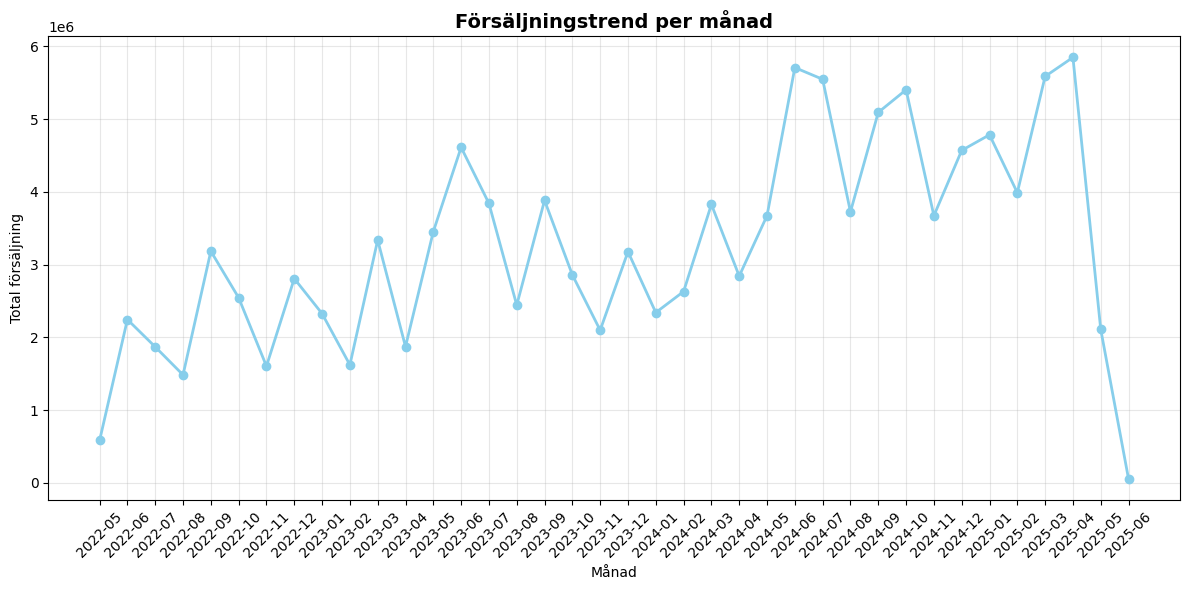

In [23]:
# Define SQL query to get total sales per month
query_vis3 = """
SELECT 
    FORMAT(OrderDate, 'yyyy-MM') AS OrderMonth,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY FORMAT(OrderDate, 'yyyy-MM')
ORDER BY OrderMonth
"""

# Execute the SQL query
df = pd.read_sql(query_vis3, engine)

# Create figure for line plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the sales trend as a line chart
ax.plot(df['OrderMonth'], df['TotalSales'], marker='o', linewidth=2, color='skyblue')

# Set title and labels
ax.set_title('Försäljningstrend per månad', fontsize=14, fontweight='bold')
ax.set_xlabel('Månad')
ax.set_ylabel('Total försäljning')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Add grid for better readability
ax.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

# 4. Försäljning och antal ordrar per år

Affärsfråga: Hur ser total försäljning och antal ordrar ut per år?

Metod: Gruppera per år och beräkna både total försäljning och orderantal.

Insikt: Jämförelse mellan år visar om försäljning och ordervolym följs åt.

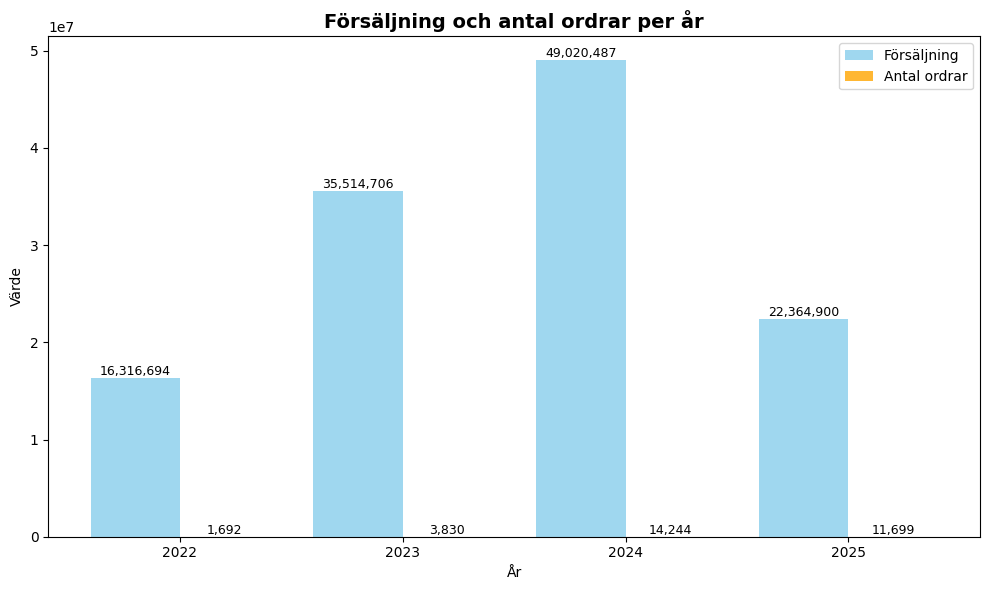

In [24]:
# SQL-query för att hämta försäljning och antal ordrar per år
query_vis4 = """
SELECT 
    YEAR(OrderDate) AS OrderYear,
    COUNT(SalesOrderID) AS OrderCount,
    SUM(TotalDue) AS TotalSales
FROM Sales.SalesOrderHeader
GROUP BY YEAR(OrderDate)
ORDER BY OrderYear
"""

# Läs in resultatet
df = pd.read_sql(query_vis4, engine)

# Skapa x-positioner för staplarna
x = range(len(df))

# Skapa figur med primär och sekundär y-axel
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotta TotalSales som staplar
bars1 = ax1.bar([i - 0.2 for i in x], df['TotalSales'], width=0.4, 
                label='Försäljning', color='skyblue', alpha=0.8)

# Plotta OrderCount som staplar bredvid
bars2 = ax1.bar([i + 0.2 for i in x], df['OrderCount'], width=0.4, 
                label='Antal ordrar', color='orange', alpha=0.8)

# Sätt etiketter och titel
ax1.set_xlabel('År')
ax1.set_ylabel('Värde')
ax1.set_title('Försäljning och antal ordrar per år', fontsize=14, fontweight='bold')

# Sätt x-ticks
ax1.set_xticks(x)
ax1.set_xticklabels(df['OrderYear'])

# Lägg till värden ovanpå staplarna
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# Lägg till legend
ax1.legend()

# Justera layout
plt.tight_layout()

# Visa diagrammet
plt.show()

# 5. Top 10 produkter

Affärsfråga: Vilka 10 produkter genererar mest försäljning?

Metod: Summera försäljning per produkt och välj topp 10.

Insikt: Identifierar #1-produkten och dominerande kategorier i topp 10.

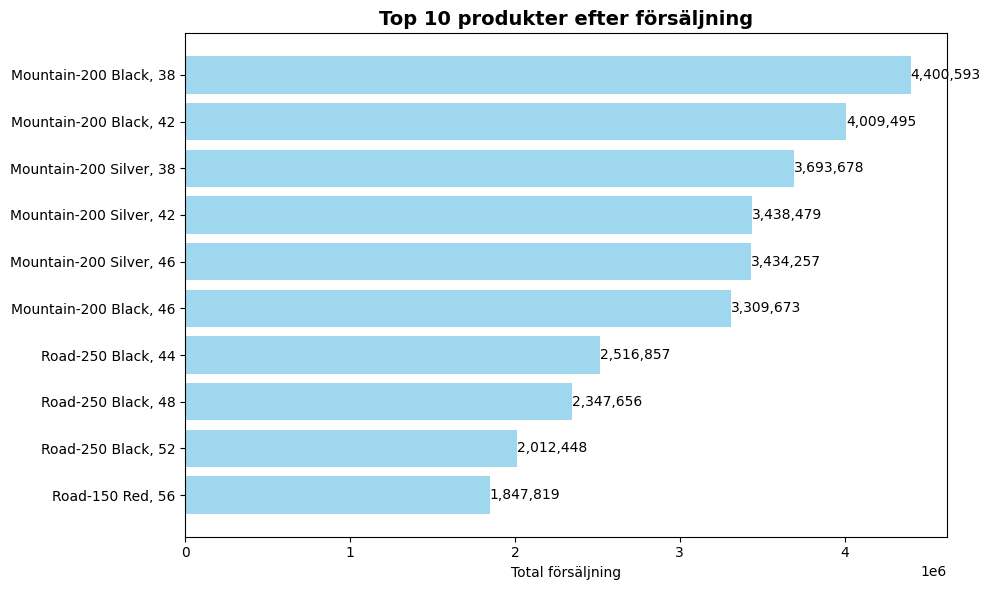

In [25]:
# SQL-query för att hämta de 10 produkter med högst försäljning
query_vis5 = """
SELECT TOP 10
    p.Name AS Product,
    SUM(sod.LineTotal) AS TotalSales
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p ON sod.ProductID = p.ProductID
GROUP BY p.Name
ORDER BY TotalSales DESC
"""

# Läs in resultatet
df = pd.read_sql(query_vis5, engine)

# Skapa figur för horisontellt stapeldiagram
fig, ax = plt.subplots(figsize=(10, 6))

# Plotta horisontella staplar
bars = ax.barh(df['Product'], df['TotalSales'], color='skyblue', alpha=0.8)

# Lägg till värdet på varje stapel
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height() / 2,
            f'{width:,.0f}', va='center')

# Sätt titel och etiketter
ax.set_title('Top 10 produkter efter försäljning', fontsize=14, fontweight='bold')
ax.set_xlabel('Total försäljning')

# Vänd y-axeln så att högst är överst
ax.invert_yaxis()

# Justera layout
plt.tight_layout()

# Visa diagrammet
plt.show()

# 6. Försäljning och antal kunder per region

Affärsfråga: Hur skiljer sig försäljningen mellan regioner och hur många kunder finns i varje?

Metod: Aggregera per territorium, räkna unika kunder.

Insikt: Visar om hög försäljning beror på många kunder eller högre ordervärde.

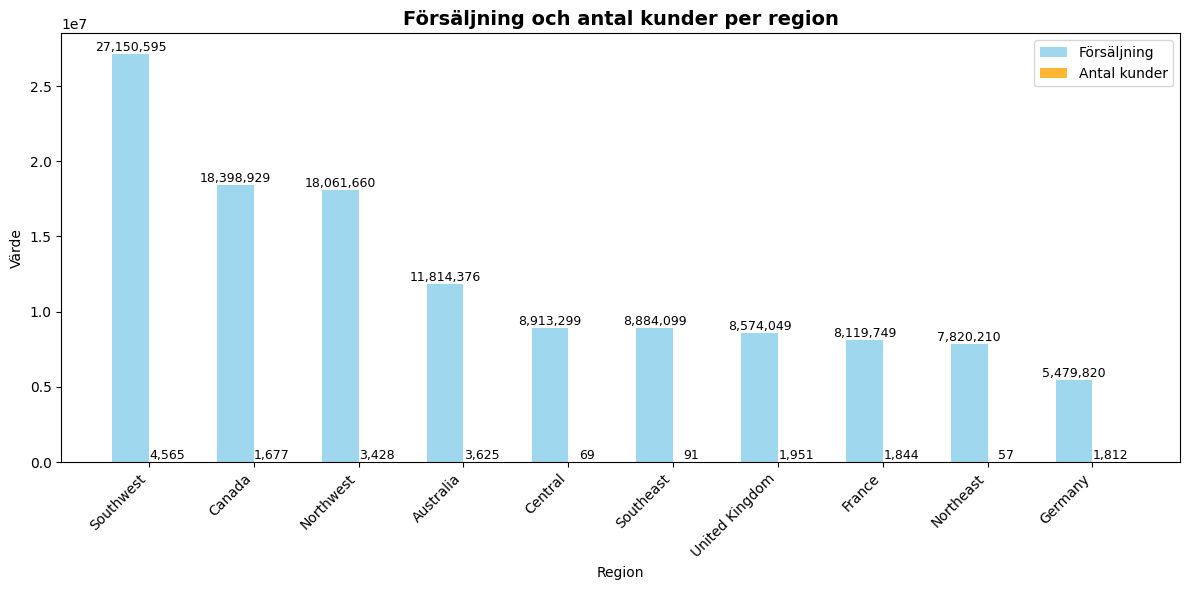

In [26]:
# SQL-query: total sales and customer count per region
query_vis6 = """
SELECT 
    st.Name AS Region,
    SUM(soh.TotalDue) AS TotalSales,
    COUNT(DISTINCT soh.CustomerID) AS CustomerCount
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
GROUP BY st.Name
ORDER BY TotalSales DESC
"""

# Load data
df = pd.read_sql(query_vis6, engine)

# X positions for the bars
x = range(len(df))

# Create figure
fig, ax = plt.subplots(figsize=(12, 6))

# Bar width
bar_width = 0.35

# Plot TotalSales bars
bars1 = ax.bar([i - bar_width/2 for i in x], df['TotalSales'], 
               width=bar_width, label='Försäljning', color='skyblue', alpha=0.8)

# Plot CustomerCount bars
bars2 = ax.bar([i + bar_width/2 for i in x], df['CustomerCount'], 
               width=bar_width, label='Antal kunder', color='orange', alpha=0.8)

# Set x-ticks and labels
ax.set_xticks(x)
ax.set_xticklabels(df['Region'], rotation=45, ha='right')

# Title and labels
ax.set_title('Försäljning och antal kunder per region', fontsize=14, fontweight='bold')
ax.set_xlabel('Region')
ax.set_ylabel('Värde')
ax.legend()

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# 7. Genomsnittligt ordervärde per region och kundtyp

Affärsfråga: Vilka regioner och kundtyper har högst genomsnittligt ordervärde?

Metod: Beräkna AOV = total försäljning / antal ordrar, uppdelat på Store vs Individual.

Insikt: Företagskunder (Store) har ofta högre ordervärde; skillnader varierar mellan regioner.

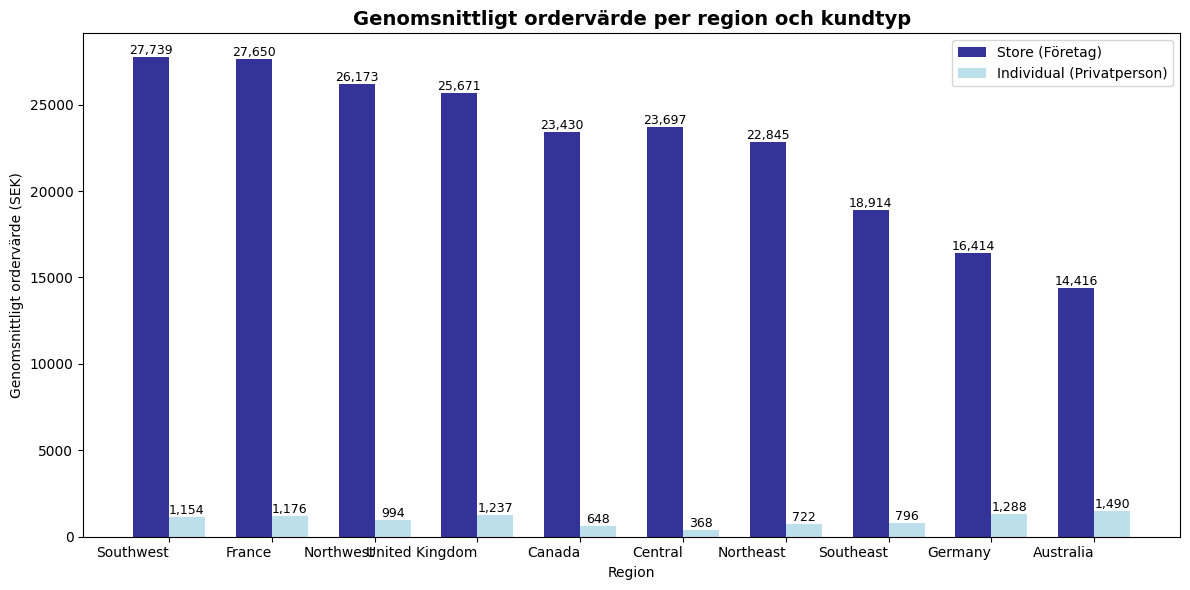

In [27]:
# SQL-query för genomsnittligt ordervärde per region och kundtyp
query_vis7 = """
SELECT 
    st.Name AS Region,
    CASE 
        WHEN s.BusinessEntityID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END AS CustomerType,
    COUNT(DISTINCT soh.SalesOrderID) AS OrderCount,
    SUM(soh.TotalDue) AS TotalSales,
    AVG(soh.TotalDue) AS AvgOrderValue
FROM Sales.SalesOrderHeader soh
JOIN Sales.SalesTerritory st ON soh.TerritoryID = st.TerritoryID
LEFT JOIN Sales.Customer c ON soh.CustomerID = c.CustomerID
LEFT JOIN Sales.Store s ON c.StoreID = s.BusinessEntityID
GROUP BY st.Name, 
    CASE 
        WHEN s.BusinessEntityID IS NOT NULL THEN 'Store'
        ELSE 'Individual'
    END
ORDER BY AVG(soh.TotalDue) DESC
"""

# Läs in resultatet
df = pd.read_sql(query_vis7, engine)

# Pivotera data för grupperat stapeldiagram
pivot_df = df.pivot(index='Region', columns='CustomerType', values='AvgOrderValue')

# Sortera efter högst genomsnittligt ordervärde (totalt)
region_avg = pivot_df.mean(axis=1)
pivot_df = pivot_df.loc[region_avg.sort_values(ascending=False).index]

# Skapa figur
fig, ax = plt.subplots(figsize=(12, 6))

# Plotta grupperat stapeldiagram
x = range(len(pivot_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], pivot_df['Store'], 
               width=width, label='Store (Företag)', color='navy', alpha=0.8)
bars2 = ax.bar([i + width/2 for i in x], pivot_df['Individual'], 
               width=width, label='Individual (Privatperson)', color='lightblue', alpha=0.8)

# Sätt etiketter och titel
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index, ha='right')
ax.set_xlabel('Region')
ax.set_ylabel('Genomsnittligt ordervärde (SEK)')
ax.set_title('Genomsnittligt ordervärde per region och kundtyp', fontsize=14, fontweight='bold')
ax.legend()

# Lägg till värden på staplarna
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if not pd.isna(height):
            ax.text(bar.get_x() + bar.get_width()/2, height,
                   f'{height:,.0f}', ha='center', va='bottom', fontsize=9)

# Justera layout
plt.tight_layout()

# Visa diagrammet
plt.show()